<a href="https://colab.research.google.com/github/Said20038/DeepLearning/blob/main/Tutoriel_Encoder_Decoder_LSTM_a%CC%80_comple%CC%80ter_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Encoder–Decoder LSTM pour traduction Anglais–Français
## Dataset : englishfrench.csv (colonnes English, French)

## Lien Data Set: https://drive.google.com/file/d/1OheJMYnZMLVEj4lwFEKL-3fogQkcY9Ae/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# 1-Chargement du dataset

In [ ]:
df = pd.read_csv("englishfrench1.csv", sep=",", engine="python", on_bad_lines="skip")
df

,English,French;;
0,Hi.,Salut!;;
1,Run!,Cours !;;
2,Run!,Courez !;;
3,Who?,Qui ?;;
4,Wow!,Ça alors !;;
...,...,...
161439,Food prices are at their highest level since t...,Les prix de l'alimentation sont à leur plus ha...
161440,The teacher supervising the playground became ...,L'institutrice chargée de surveiller la cour s...
161441,People tend to only compliment you on your lan...,Les gens ont tendance à vous complimenter sur ...
161442,A child who is a native speaker usually knows ...,Un enfant qui est un locuteur natif connaît ha...


In [ ]:
df.shape

(161444, 2)

In [ ]:
df.dtypes

,0
English,object
French;;,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161444 entries, 0 to 161443
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   English   161444 non-null  object
 1   French;;  161444 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [ ]:
df.head(10)

,English,French;;
0,Hi.,Salut!;;
1,Run!,Cours !;;
2,Run!,Courez !;;
3,Who?,Qui ?;;
4,Wow!,Ça alors !;;
5,Fire!,Au feu !;;
6,Help!,À l'aide !;;
7,Jump.,Saute.;;
8,Stop!,Ça suffit !;;
9,Stop!,Stop !;;


In [ ]:
df.isnull().sum()

,0
English,0
French;;,0


In [ ]:
df = pd.read_csv("englishfrench1.csv", sep=",", engine="python", on_bad_lines="skip")

# Normalisation des noms de colonnes (enlève espaces, met en minuscule)
df.columns = df.columns.str.strip().str.lower()
print("Colonnes détectées :", df.columns.tolist())

# Recherche automatique des colonnes anglaises et françaises
eng_col = [c for c in df.columns if "eng" in c][0]
fr_col = [c for c in df.columns if "fr" in c][0]

# Supprimer les valeurs manquantes
df = df.dropna(subset=[eng_col, fr_col])

# Échantillonnage (pour aller plus vite)
df = df.sample(n=15000, random_state=42).reset_index(drop=True)

# Ajouter les tokens de début et fin
df[fr_col] = df[fr_col].apply(lambda x: f"<start> {x} <end>")

Colonnes détectées : ['english', 'french;;']


# ================================================================
# 2- Tokenisation
# ================================================================

In [ ]:
# Anglais
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df[eng_col])
eng_sequences = eng_tokenizer.texts_to_sequences(df[eng_col])

# Français (garder tokens spéciaux <start> et <end>)
fr_tokenizer = Tokenizer(filters='', lower=False)  # important !
fr_tokenizer.fit_on_texts(df[fr_col])
fr_sequences = fr_tokenizer.texts_to_sequences(df[fr_col])

num_eng_tokens = len(eng_tokenizer.word_index) + 1
num_fr_tokens = len(fr_tokenizer.word_index) + 1

max_eng_len = max(len(seq) for seq in eng_sequences)
max_fr_len = max(len(seq) for seq in fr_sequences)

encoder_input_data = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
decoder_input_data = pad_sequences(fr_sequences, maxlen=max_fr_len, padding='post')

# Décalage de la sortie cible pour le décalage "teacher forcing"
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]



# ================================================================
# 3- Modèle Encoder–Decoder
# ================================================================

In [ ]:
latent_dim = 256

# Encoder (le code de l'encodeur reste inchangé)
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(num_eng_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_fr_len,))
dec_emb = Embedding(num_fr_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_fr_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modèle global
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 256)   │  1,442,048 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 25, 256)   │  3,219,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 25, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 12575) │  3,231,775 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,943,647 (34.12 MB)

 Trainable params: 8,943,647 (34.12 MB)

 Non-trainable params: 0 (0.00 B)

# ================================================================
# 4- Inférence (traduction)
# ================================================================

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_states2 = [state_h2, state_c2]

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# ================================================================
# 5- Entraînement
# ================================================================

In [ ]:

X1, X2, y = encoder_input_data, decoder_input_data, decoder_target_data[..., np.newaxis]
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.1, random_state=42)

history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    batch_size=64,
    epochs=10
)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.2330 - loss: 6.7737 - val_accuracy: 0.0981 - val_loss: 5.0431
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.1003 - loss: 4.7928 - val_accuracy: 0.1073 - val_loss: 4.7486
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.1109 - loss: 4.3866 - val_accuracy: 0.1181 - val_loss: 4.4595
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1239 - loss: 3.9817 - val_accuracy: 0.1238 - val_loss: 4.2666
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1335 - loss: 3.6697 - val_accuracy: 0.1330 - val_loss: 4.0960
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1442 - loss: 3.3855 - val_accuracy: 0.1360 - val_loss: 3.9955
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1529 - loss: 3.1293 - val_accuracy: 0.1417 - val_loss: 3.9181
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.1600 - loss: 2.9149 - 

# ================================================================
# 6- Fonction de traduction
# ================================================================

In [ ]:

reverse_fr_index = {i: word for word, i in fr_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fr_tokenizer.word_index["<start>"]
    decoded_sentence = ""

    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_fr_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_fr_len:
            break

        decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# ================================================================
# 7- Test du modèle
# ================================================================

In [ ]:
for i in range(5):
    input_text = df[eng_col][i]
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([input_text]), maxlen=max_eng_len, padding='post')
    translation = decode_sequence(input_seq)
    print(f"\n***English: {input_text}")
    print(f"***Prediction Français: {translation}")
    print(f"*** Français (Vérité terain) : {df[fr_col][i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

***English: Have you ever missed a plane?
***Prediction Français: Avez-vous déjà été bien en train de la fête ?;;
*** Français (Vérité terain) : <start> Est-ce que tu as déjà raté un avion ?;; <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


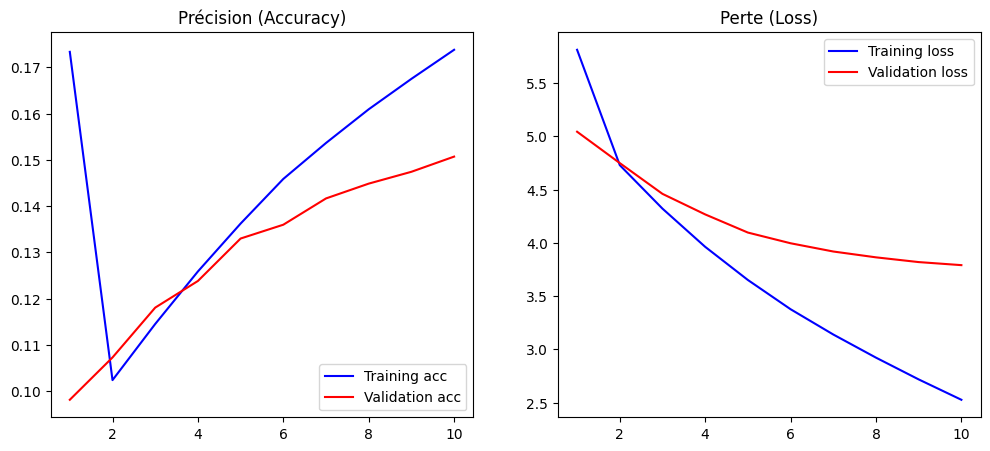

In [ ]:
import matplotlib.pyplot as plt

# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Créer le graphique
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Précision (Accuracy)')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Perte (Loss)')
plt.legend()

plt.show()

Calcul du T-SNE en cours...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


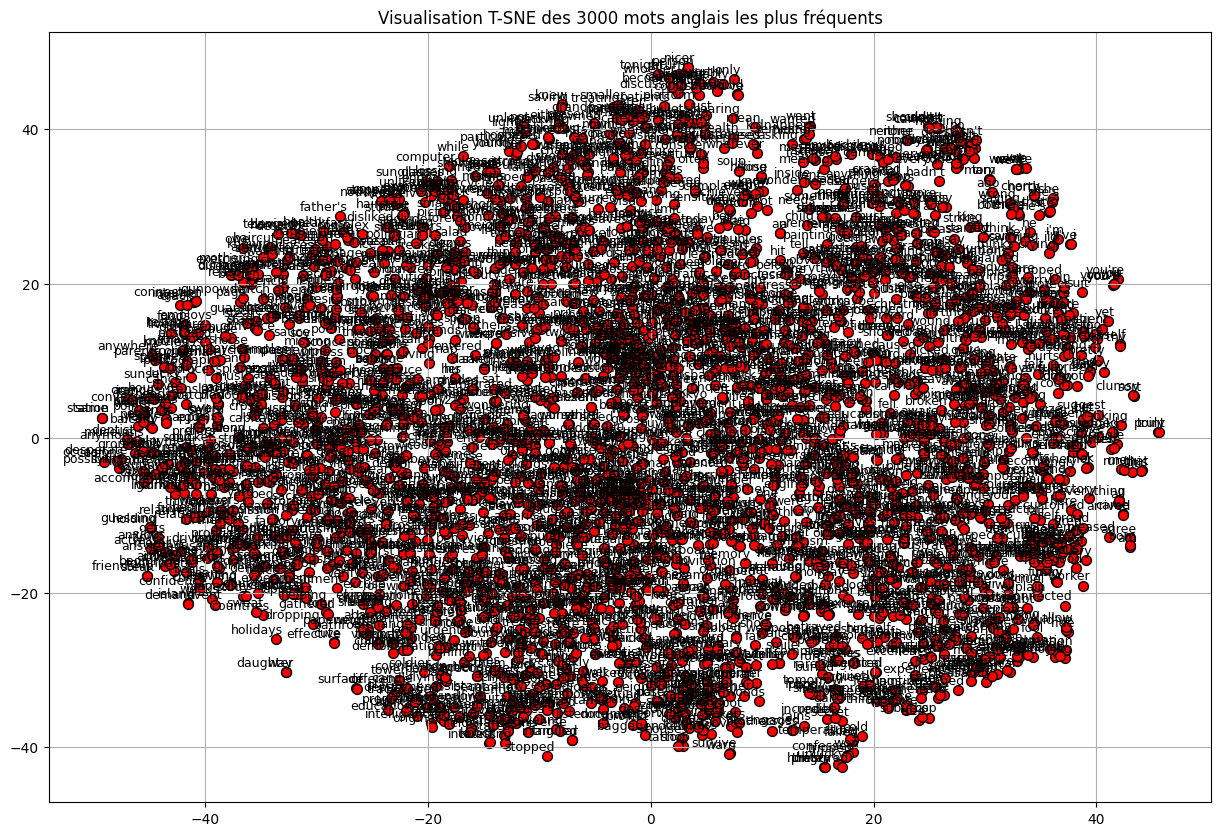

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 1. Récupérer les poids de la couche d'embedding de l'encodeur
# Dans votre résumé (summary), la première couche d'embedding s'appelle 'embedding'
embedding_layer = model.get_layer('embedding')
embedding_weights = embedding_layer.get_weights()[0]

# 2. Sélectionner les mots à visualiser
# On ne visualise que les N mots les plus fréquents pour que le graphique soit lisible
num_words_to_plot = 3000
words = []
vectors = []

# eng_tokenizer.word_index est trié par fréquence (du plus fréquent au moins fréquent)
for word, i in eng_tokenizer.word_index.items():
    if i <= num_words_to_plot:
        words.append(word)
        vectors.append(embedding_weights[i])

# Convertir en array numpy
vectors = np.array(vectors)

# 3. Appliquer T-SNE
print("Calcul du T-SNE en cours...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
vectors_2d = tsne.fit_transform(vectors)

# 4. Création du graphique
plt.figure(figsize=(15, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='red', edgecolors='k', s=50)

# Ajouter les étiquettes (les mots)
for i, word in enumerate(words):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=9)

plt.title(f"Visualisation T-SNE des {num_words_to_plot} mots anglais les plus fréquents")
plt.grid(True)
plt.show()